In [16]:
import os
import sys

sys.path.append('..')

import ffmpeg
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LogNorm, Normalize

from models.unrolled_admm_gaussian import UnrolledADMMGaussian
# from utils.utils_test import PSNR, estimate_shear

plt.rcParams['font.weight'] = 'bold'
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

DATA_PATH = '../tutorials/'
SAVED_MODEL_PATH = '../saved_models_2024/'
cmap = 'magma'

In [17]:
os.makedirs('analysis', exist_ok=True)

In [18]:
snr = 100
psf = torch.load(os.path.join(DATA_PATH, "psf.pth"))
gt, obs = torch.load(os.path.join(DATA_PATH, "gt.pth")), torch.load(os.path.join(DATA_PATH, "obs.pth"))

In [19]:
n_iters_list, best_epoch_list = [2, 4, 8], [16, 13, 38]
rec_admm = []

for idx, (n_iters, best_epoch) in enumerate(zip(n_iters_list, best_epoch_list)):
    model = UnrolledADMMGaussian(n_iters=n_iters, PnP=True, subnet=True, analysis=True).cuda()
    model.eval()
    model_file = os.path.join(SAVED_MODEL_PATH, f'Gaussian_PnP_ADMM_{n_iters}iters_MultiScale_{best_epoch}epochs.pth')
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cuda:0')))
    print(f'Successfully loaded in {model_file}.')

    # for obs, gt in zip(obs_list, gt_list):
    alpha = obs.ravel().mean().view(1,1,1,1)
    x_list, z_list, u_list, rho_list = model(obs.unsqueeze(0).unsqueeze(0).cuda(), psf.unsqueeze(0).unsqueeze(0).cuda(), alpha.cuda())
    x_list = [x.cpu().squeeze(0).squeeze(0).detach().numpy() for x in x_list]
    z_list = [z.cpu().squeeze(0).squeeze(0).detach().numpy() for z in z_list]
    rho_list = np.array([rho.view(1).detach().cpu().numpy() for rho in rho_list])
    u_list = [u.cpu().squeeze(0).squeeze(0).detach().numpy() for u in u_list]
    rec_admm.append((x_list, z_list, u_list, rho_list))

Successfully loaded in ../saved_models_2024/Gaussian_PnP_ADMM_2iters_MultiScale_16epochs.pth.
Successfully loaded in ../saved_models_2024/Gaussian_PnP_ADMM_4iters_MultiScale_13epochs.pth.
Successfully loaded in ../saved_models_2024/Gaussian_PnP_ADMM_8iters_MultiScale_38epochs.pth.


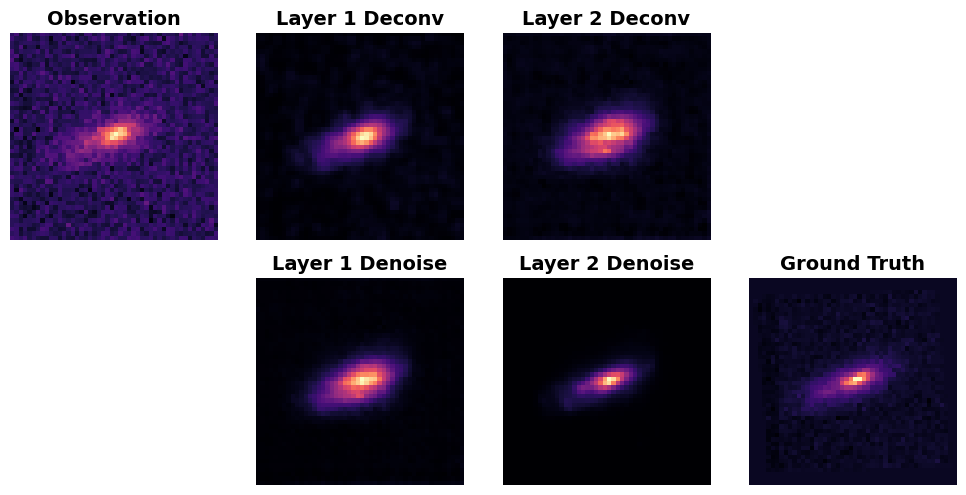

In [20]:
fig = plt.figure(figsize=(10,7.5), facecolor='white')

x_list, z_list, u_list, rho_list = rec_admm[0]
vmax = np.max([obs.max(), z_list[-1].max()])
vmin = np.min([obs.min(), z_list[-1].min()])
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

plt.subplot(3,4,1)
plt.imshow(obs, cmap=cmap)
plt.title('Observation', fontweight='bold', fontsize=14)
plt.axis('off')

plt.subplot(3,4,8)
plt.imshow(gt, cmap=cmap)
plt.title('Ground Truth', fontweight='bold', fontsize=14)
plt.axis('off')

for i in range(2):
    plt.subplot(3,4,i+2)
    # plt.imshow(rho_list[i]*z_list[i]+u_list[i], cmap=cmap)
    plt.imshow(x_list[i], cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i+1} Deconv', fontweight='bold', fontsize=14)
    
    plt.subplot(3,4,i+2+4)
    plt.imshow(z_list[i], cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i+1} Denoise', fontweight='bold', fontsize=14)
    plt.imsave(os.path.join('analysis', f'Unrolled_ADMM_2iters_SNR={snr}_x{i+1}.png'), x_list[i], cmap=cmap)
    plt.imsave(os.path.join('analysis', f'Unrolled_ADMM_2iters_SNR={snr}_z{i+1}.png'), z_list[i], cmap=cmap)
plt.tight_layout()
plt.savefig(f'Unrolled_ADMM_2iters_SNR={snr}.png', dpi=128)

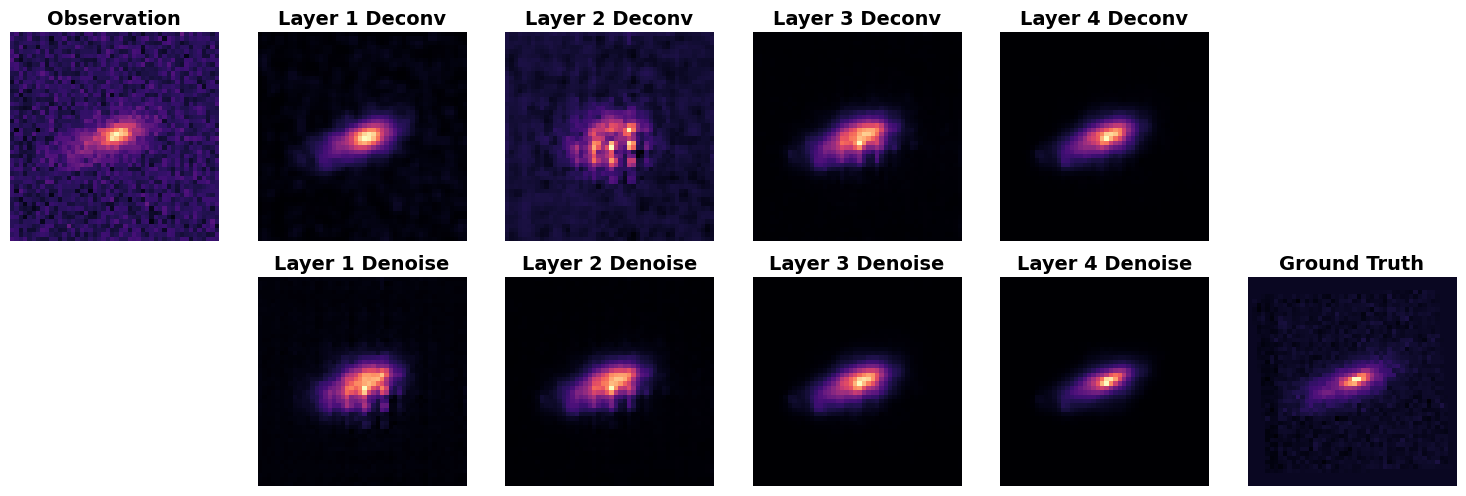

In [21]:
fig = plt.figure(figsize=(15,7.5), facecolor='white')

x_list, z_list, u_list, rho_list = rec_admm[1]

plt.subplot(3,6,1)
plt.imshow(obs, cmap=cmap)
plt.title('Observation', fontweight='bold', fontsize=14)
plt.axis('off')

plt.subplot(3,6,12)
plt.imshow(gt, cmap=cmap)
plt.title('Ground Truth', fontweight='bold', fontsize=14)
plt.axis('off')

for i in range(4):
    plt.subplot(3,6,i+2)
    plt.imshow(x_list[i], cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i+1} Deconv', fontweight='bold', fontsize=14)
    
    plt.subplot(3,6,i+2+6)
    plt.imshow(z_list[i], cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i+1} Denoise', fontweight='bold', fontsize=14)
    plt.imsave(os.path.join('analysis', f'Unrolled_ADMM_8iters_SNR={snr}_x{i+1}.png'), x_list[i], cmap=cmap)
    plt.imsave(os.path.join('analysis', f'Unrolled_ADMM_8iters_SNR={snr}_z{i+1}.png'), z_list[i], cmap=cmap)
plt.tight_layout()
plt.savefig(f'Unrolled_ADMM_8iters_SNR={snr}.png', dpi=128)

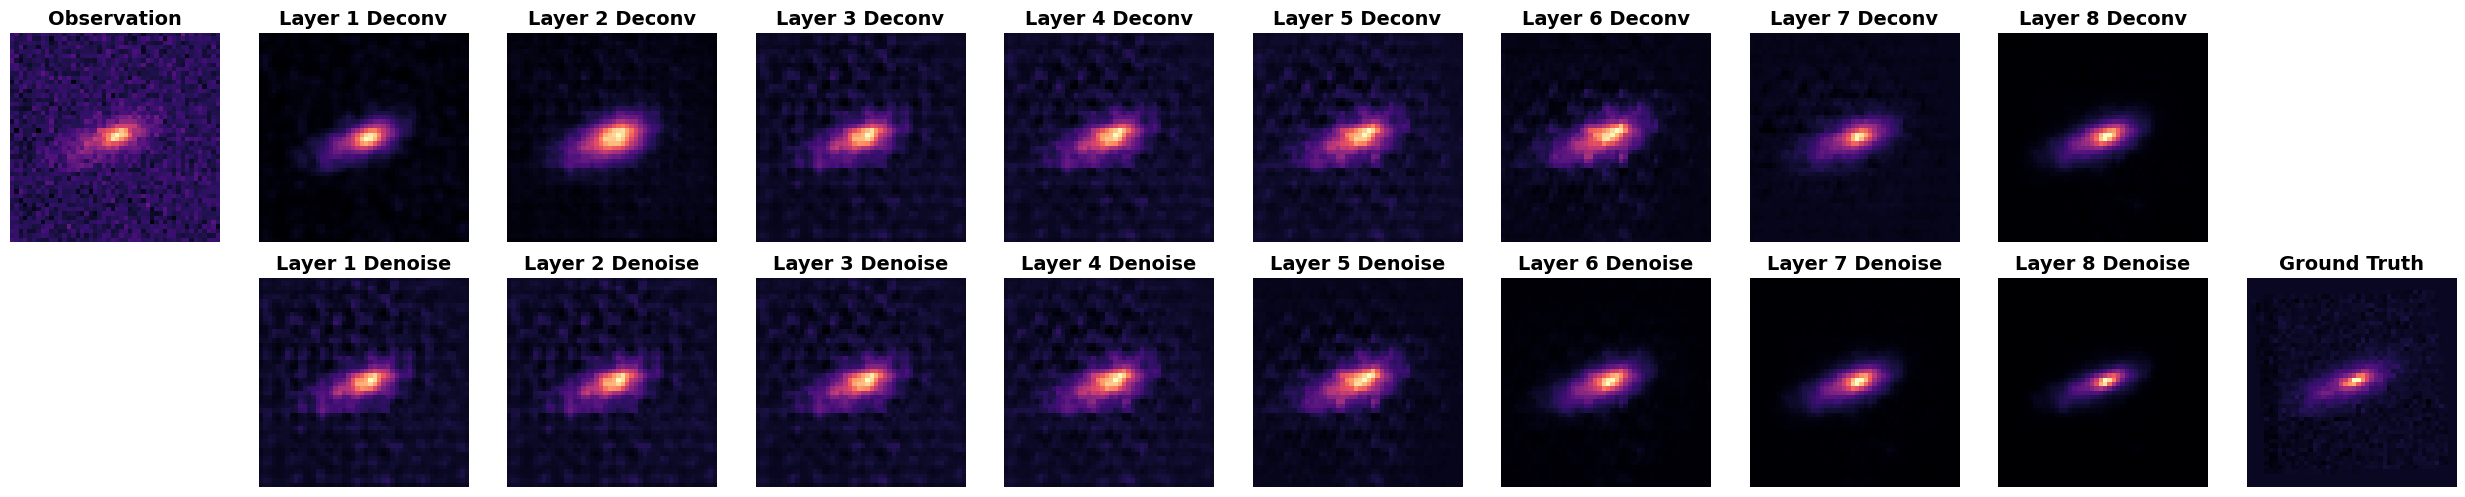

In [22]:
fig = plt.figure(figsize=(25,7.5), facecolor='white')

x_list, z_list, u_list, rho_list = rec_admm[2]

plt.subplot(3,10,1)
plt.imshow(obs, cmap=cmap)
plt.title('Observation', fontweight='bold', fontsize=14)
plt.axis('off')

plt.subplot(3,10,20)
plt.imshow(gt, cmap=cmap)
plt.title('Ground Truth', fontweight='bold', fontsize=14)
plt.axis('off')

for i in range(8):
    plt.subplot(3,10,i+2)
    plt.imshow(x_list[i], cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i+1} Deconv', fontweight='bold', fontsize=14)
    
    plt.subplot(3,10,i+2+10)
    plt.imshow(z_list[i], cmap=cmap)
    plt.axis('off')
    plt.title(f'Layer {i+1} Denoise', fontweight='bold', fontsize=14)
    plt.imsave(os.path.join('analysis', f'Unrolled_ADMM_8iters_SNR={snr}_x{i+1}.png'), x_list[i], cmap=cmap)
    plt.imsave(os.path.join('analysis', f'Unrolled_ADMM_8iters_SNR={snr}_z{i+1}.png'), z_list[i], cmap=cmap)
plt.tight_layout()
plt.savefig(f'Unrolled_ADMM_8iters_SNR={snr}.png', dpi=128)

In [23]:
# fig = plt.figure(figsize=(21,7), facecolor='white')
# ax = plt.gca()

# for idx, (snr, gt, obs, (x_list, z_list, u_list, rho_list)) in enumerate(zip(snr_list, gt_list, obs_list, rec_admm[2])):
#     vmax = 2*np.max([obs[0].max(), z_list[-1].max()])
#     vmin = 0*np.min([obs[0].min(), z_list[-1].min()])
#     norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

#     plt.subplot(3,10,10*idx+1)
#     plt.imshow(obs, cmap=cmap)
#     plt.title('Input')
#     plt.axis('off')
    
#     plt.subplot(3,10,10*idx+20)
#     plt.imshow(gt, cmap=cmap)
#     plt.title('Ground Truth')
#     plt.axis('off')
    
#     for i in range(8):
#         plt.subplot(3,10,10*idx+i+2)
#         plt.imshow(np.abs(x_list[i]), cmap=cmap)
#         plt.axis('off')
#         plt.title(f'Layer {i+1} Deconv')
        
#         plt.subplot(3,10,10*idx+i+2+10)
#         plt.imshow(z_list[i], cmap=cmap)
#         plt.axis('off')
#         plt.title(f'Layer {i+1} Denoise')
        
#         # plt.subplot(3,10,10*idx+i+2+20)
#         # plt.imshow(u_list[i], cmap=cmap)
#         # plt.axis('off')
#         # plt.title(f'Layer {i+1} Dual')
#         # plt.imsave(f'../figures/press_release/Unrolled-ADMM(8)iters_SNR={snr}_layer{i+1}.jpg', rec, cmap=cmap)


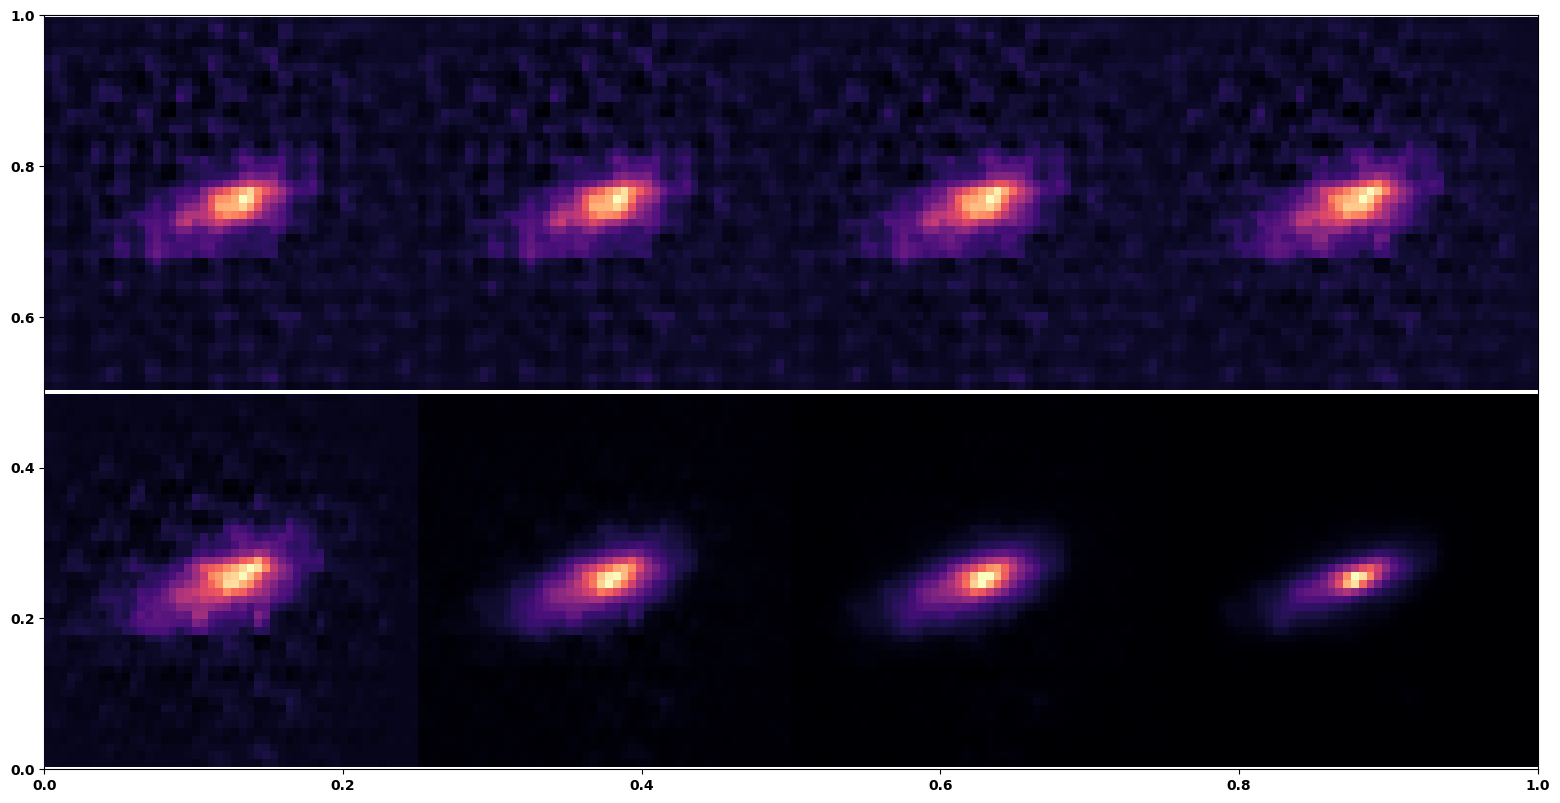

In [24]:
fig = plt.figure(figsize=(15.7,8), facecolor='white')
ax = plt.gca()
z_list = rec_admm[2][1]
gs = plt.GridSpec(2,4)
for idx, z in enumerate(z_list):
    ax = plt.subplot(gs[idx//4,idx%4])
    plt.imshow(z, cmap=cmap)
    plt.axis('off')
    ax.set_aspect('equal')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('../figures/layers8.png', dpi=128, bbox_inches='tight')

### Create video

In [25]:
os.makedirs('video', exist_ok=True)

In [26]:
for idx in range(9):
    fig = plt.figure(figsize=(15,8), facecolor='white')
    plt.subplot(1,2,1)
    plt.imshow(obs, cmap=cmap)
    # plt.title('Observation', color='white', fontweight='bold', fontsize=26, y=0.91)
    plt.axis('off')
    
    plt.subplot(1,2,2)
    if idx == 0:
        plt.imshow(obs, cmap=cmap)
        # plt.title('Observation', color='white', fontweight='bold', fontsize=26, y=0.91)
    else:
        plt.imshow(x_list[idx-1], cmap=cmap)
        # plt.title(f'Layer {idx}', color='white', fontweight='bold', fontsize=26, y=0.91)
    plt.axis('off')
    
    plt.savefig(os.path.join('video', f'Unrolled_ADMM_8iters_{str(idx).zfill(2)}.png'), dpi=64, bbox_inches='tight', transparent=True)
    plt.close()

In [27]:
frame_rate = 3

In [28]:
(
    ffmpeg
    .input(os.path.join('video', 'Unrolled_ADMM_8iters_*.png'), pattern_type='glob', framerate=frame_rate)
    .output(os.path.join('video', 'Unrolled_ADMM_8iters.mp4'), vcodec='h264')
    .overwrite_output()
    .run()
)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(None, None)